In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 2.1 MB/s 
     |████████████████████████████████| 291 kB 48.8 MB/s 
     |████████████████████████████████| 856 kB 48.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pybaseball

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Data**

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value']

In [ ]:
#get the statcast data from 2021

raw21 = pybaseball.statcast(start_dt = '2021-01-01', end_dt = '2021-12-31')
#drop unneeded columns 
raw21 = raw21[needed_columns]

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [18:27<00:00,  4.50s/it]


In [ ]:
#get the statcast data from 2022

raw22 = pybaseball.statcast(start_dt = '2022-01-01', end_dt = '2022-12-31')
raw22 = raw22[needed_columns]

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [16:38<00:00,  4.06s/it]


In [ ]:
#clean the data and define the train and test sets 

df21 = organize_data(raw21)
df22 = organize_data(raw22)

train = df21.copy()
test = df22.copy()
all_data = train.append(test, ignore_index = True)

In [ ]:
#define the run values by count and by event 
count_runs = pd.DataFrame({'balls_pre_event': [2, 2, 0, 0, 1, 2, 1, 0, 1, 3, 3, 3], 
                           'strikes_pre_event': [1, 0, 2, 0, 2, 2, 0, 1, 1, 2, 1, 0],
                           'run_expectancy': [0.5268, 0.604 , 0.3858, 0.494 , 0.4081, 0.4492, 0.5312, 0.4434,
       0.4737, 0.5537, 0.6406, 0.7179]})

event_runs = pd.DataFrame({'run_so': -0.2745, 'run_bb':  0.3399, 'run_bip_out': -0.2741, 'run_1b':  0.4685, 'run_2b':  0.7607, 'run_3b':  1.0476,'run_hr':  1.3749}, index = [0])

In [ ]:
#z score continuous variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

train[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(train[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

test[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(test[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

In [ ]:
#get the batter and pitcher index 
batter_indices = pd.DataFrame({'batter': train.batter.unique()})
pitcher_indices = pd.DataFrame({'pitcher': train.pitcher.unique()})
test = test.loc[test.batter.isin(train.batter.unique())]
test = test.loc[test.pitcher.isin(train.pitcher.unique())]

batter_indices['batter_index'] = batter_indices.index.values
pitcher_indices['pitcher_index'] = pitcher_indices.index.values

#merge 
train = train.merge(batter_indices, on = 'batter')
train = train.merge(pitcher_indices, on = 'pitcher')
test = test.merge(batter_indices, on = 'batter')
test = test.merge(pitcher_indices, on = 'pitcher')

In [ ]:
#data set class 
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
        self.length = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length
    
#convert to torch. Note if you end up doing a batter and pitcher embedding, remove pitch hand from the featuers, but if you just have a batter embedding then keep pitch hand
xswing_feats = ['release_speed', 'mx',
 'mz', 'release_spin_rate',
 'plate_x',
 'plate_z', 'bat_handR', 'pit_handR',
 'balls',
 'strikes', 'batter_index']

train_x = train[xswing_feats].values.astype(float)
train_y = train.outcome.values
test_x = test[xswing_feats].values.astype(float)
test_y = test.outcome.values

trainset = DataSet(train_x, train_y)
testset = DataSet(test_x, test_y)

#data loaders 
trainloader = DataLoader(trainset, batch_size = 128, shuffle = False)
testloader = DataLoader(testset, batch_size = 128, shuffle = False)

**Model**

In [ ]:
#network hyperparameters 
VEC_SIZE = 13

class BatterPitch2Vec(nn.Module):
    def __init__(self):
        super().__init__()
        self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = VEC_SIZE)
        self.input_layer = nn.Linear(in_features = VEC_SIZE + len(xswing_feats) - 1, out_features = 250)
        self.hidden_layer = nn.Linear(in_features = 250, out_features= 125)
        self.hidden_layer1 = nn.Linear(in_features = 125, out_features = 64)
        self.hidden_layer2 = nn.Linear(in_features = 64, out_features = 32)
        self.output_layer = nn.Linear(in_features = 32, out_features = 9)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #x has a column for every entry in xswing_feats. The last column is the batter, so that's what we would feed into the batter embedding. 
        batter_idx = x[:,x.shape[1] - 1]
        batter_idx = batter_idx.int()
        batter_embedding = self.batter_embedding(batter_idx)
        #concatenate the embedding with the rest of x 
        concatenated = torch.cat((batter_embedding, x[:,:x.shape[1] - 1]),1)
        output = self.relu(self.input_layer(concatenated))
        output = self.relu(self.hidden_layer(output))
        output = self.relu(self.hidden_layer1(output))
        output = self.relu(self.hidden_layer2(output))
        output = self.output_layer(output) #don't need to apply softmax because the loss function crossentropyloss does that for us.
        
        return output

In [ ]:
#training: set hyperparameters
learning_rate = 1e-5
epochs = 20  #might be worth it to do like 40 epochs or more.

model = BatterPitch2Vec().to(device)
#the initial weights for the batter has a big effect on the embedding, so initialize them all to 0 
model.batter_embedding.weight.data.fill_(1.)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#training: loops 
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
    #tell the model that we're training now 
    model.train()
    #loop through batches of training data 
    loss_val = 0
    num_correct =  0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients 
        optimizer.zero_grad()
        #run the model 
        outputs = model(x)
        #calculate loss 
        loss = loss_fn(outputs, y_truth)
        loss_val += loss.item()
         #acc
        predicted = outputs.cpu().detach().numpy().argmax(axis = 1)
        num_correct += np.sum(predicted == y_truth.cpu().numpy())
        
        #backprop 
        loss.backward()
        optimizer.step()
        
        
    train_losses.append(loss_val / len(trainloader))
    train_accs.append(num_correct / (len(trainloader) * 128))
    
    model.eval()
    loss_val = 0
    num_correct = 0
    for batch, (x, y_truth) in enumerate(testloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        preds = model(x)
        
        #loss
        loss = loss_fn(preds, y_truth)
        loss_val += loss.item()
        #acc
        predicted = preds.cpu().detach().numpy().argmax(axis = 1)
        num_correct += np.sum(predicted == y_truth.cpu().numpy())
       
    
    test_losses.append(loss_val/ len(testloader))
    test_accs.append(num_correct / (len(testloader) * 128))
    
    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/20, loss = 1.794560
epoch : 2/20, loss = 1.415543
epoch : 3/20, loss = 1.273997
epoch : 4/20, loss = 1.241408
epoch : 5/20, loss = 1.225149
epoch : 6/20, loss = 1.212321
epoch : 7/20, loss = 1.201434
epoch : 8/20, loss = 1.192712
epoch : 9/20, loss = 1.185993
epoch : 10/20, loss = 1.180668
epoch : 11/20, loss = 1.176323
epoch : 12/20, loss = 1.172648
epoch : 13/20, loss = 1.169450
epoch : 14/20, loss = 1.166601
epoch : 15/20, loss = 1.164035
epoch : 16/20, loss = 1.161715
epoch : 17/20, loss = 1.159613
epoch : 18/20, loss = 1.157707
epoch : 19/20, loss = 1.155979
epoch : 20/20, loss = 1.154398


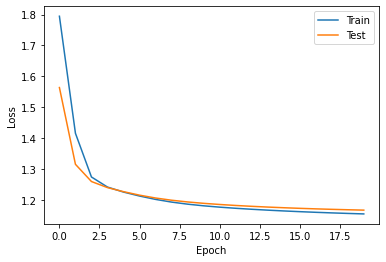

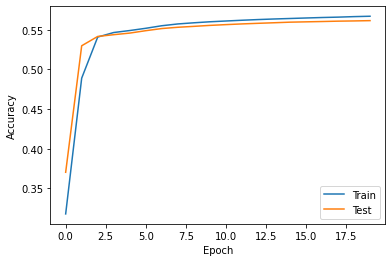

In [ ]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label = 'Train')
plt.plot(test_accs, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Plots for Abstract**

In [ ]:
#calibration 
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

In [ ]:
train_preds = nn.functional.softmax(model(torch.tensor(train_x, dtype = torch.float32).to(device)), dim = 1).cpu().detach().numpy()
test_preds = nn.functional.softmax(model(torch.tensor(test_x, dtype = torch.float32).to(device)), dim = 1).cpu().detach().numpy()

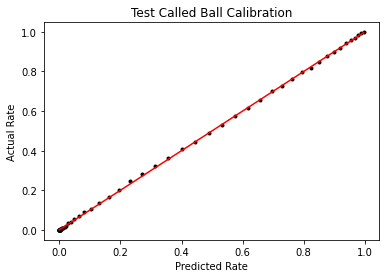

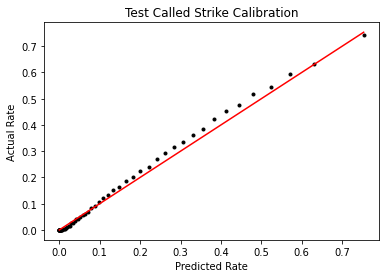

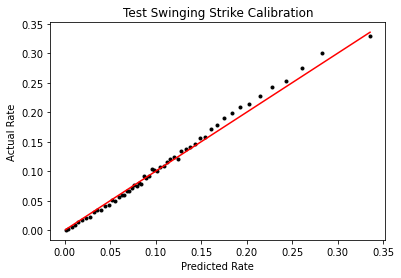

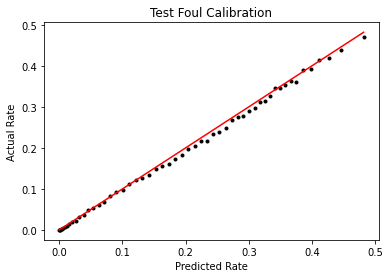

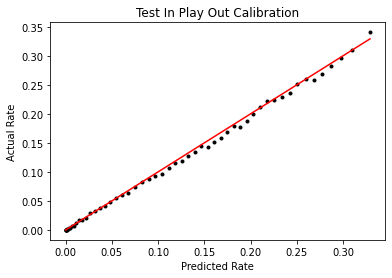

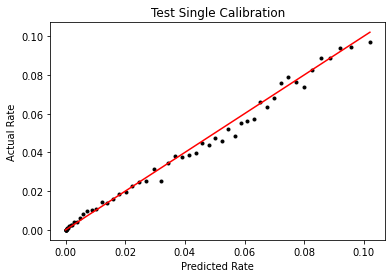

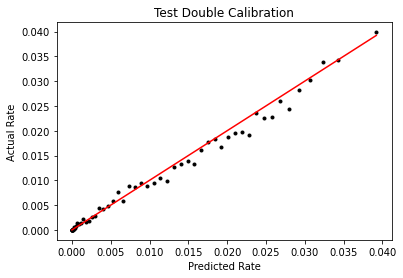

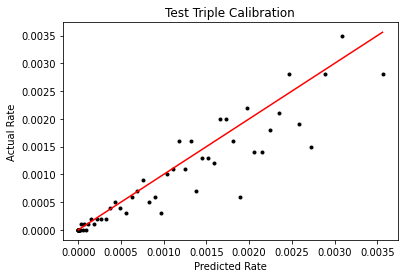

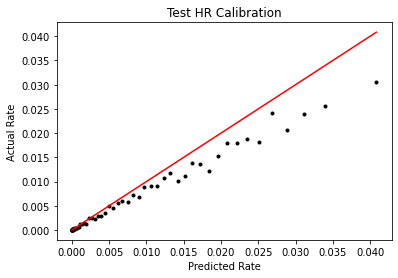

In [ ]:
calibration(test_preds[:,0], (test_y == 0).astype(bool).astype(int))
plt.title('Test Called Ball Calibration')
plt.show()

calibration(test_preds[:,1], (test_y == 1).astype(bool).astype(int))
plt.title('Test Called Strike Calibration')
plt.show()

calibration(test_preds[:,2], (test_y == 2).astype(bool).astype(int))
plt.title('Test Swinging Strike Calibration')
plt.show()

calibration(test_preds[:,3], (test_y == 3).astype(bool).astype(int))
plt.title('Test Foul Calibration')
plt.show()

calibration(test_preds[:,4], (test_y == 4).astype(bool).astype(int))
plt.title('Test In Play Out Calibration')
plt.show()

calibration(test_preds[:,5], (test_y == 5).astype(bool).astype(int))
plt.title('Test Single Calibration')
plt.show()

calibration(test_preds[:,6], (test_y == 6).astype(bool).astype(int))
plt.title('Test Double Calibration')
plt.show()

calibration(test_preds[:,7], (test_y == 7).astype(bool).astype(int))
plt.title('Test Triple Calibration')
plt.show()

calibration(test_preds[:,8], (test_y == 8).astype(bool).astype(int))
plt.title('Test HR Calibration')

plt.show()

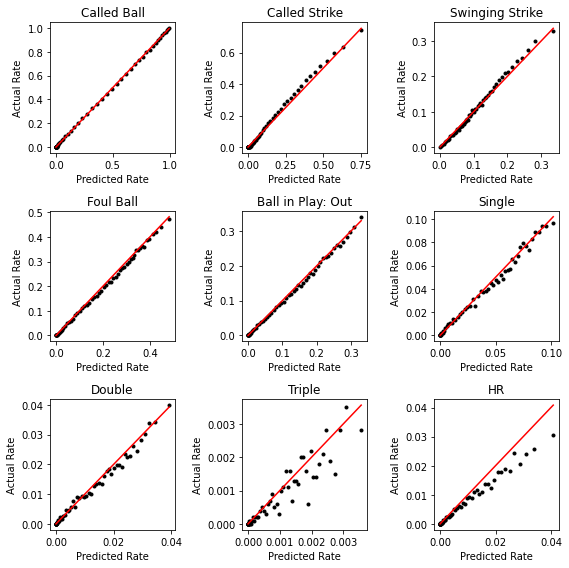

In [ ]:
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(test_preds[:,0], (test_y == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(test_preds[:,1], (test_y == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(test_preds[:,2], (test_y == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(test_preds[:,3], (test_y == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(test_preds[:,4], (test_y == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(test_preds[:,5], (test_y == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(test_preds[:,6], (test_y == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(test_preds[:,7], (test_y == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(test_preds[:,8], (test_y == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

**Utility Function**

In [ ]:
def get_utilities(pitch_df):
  '''
  pitch_df is a pandas dataframe with a column for balls, strikes, and the 
  probabilities of each outcome, named o1, o2, o3, o4, o5, o6, o7, and o8

  Returns the expected utility of a swing and of a take for that pitch.
  The batter's optimal utility for the pitch is the larger of those two values
  '''

  pitch_df['swing_utility'] = -1 
  pitch_df['take_utility'] = -1
  for balls in pitch_df.balls.unique():
    for strikes in pitch_df.strikes.unique():
      d = pitch_df.loc[(pitch_df.balls == balls) & (pitch_df.strikes == strikes)]

      #get the pre pitch run expectancy 
      count_pre_expt = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes), 'run_expectancy'].values[0]

      #get the value of a called ball 
      if balls == 3:
        #walk 
        val0 = 0.3399 
      else:
        ball_val = count_runs.loc[(count_runs.balls_pre_event == balls + 1) & (count_runs.strikes_pre_event == strikes), 'run_expectancy'].values[0]
        val0 = ball_val - count_pre_expt 

      #get the value of a called or swinging strike 
      if strikes == 2:
        #strikeout 
        val12 = -0.2745 
      else:
        strike_val = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes+1), 'run_expectancy'].values[0]
        val12 = strike_val - count_pre_expt

      #value of a foul ball 
      if strikes == 2:
        #no change 
        val3 = 0 
      else:
        val3 = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes+1), 'run_expectancy'].values[0] - count_pre_expt 

      #value of ball in play out 
      val4 = -0.2741 
      #single 
      val5 = 0.4685
      #double 
      val6 = 0.7607 
      #triple 
      val7 = 1.0476
      #hr 
      val8 = 1.3749

      #calculate utilities 
      no_swing = d.o0.values + d.o1.values 
      swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
      take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
      swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
      d.swing_utility = swing_utility 
      d.take_utility = take_utility  
      pitch_df.loc[(pitch_df.strikes == strikes) & (pitch_df.balls == balls), ['swing_utility', 'take_utility']] = d[['swing_utility', 'take_utility']].values

  return pitch_df       


In [ ]:
#example of calculating utilities 
import warnings
warnings.filterwarnings('ignore')

test_preds = nn.functional.softmax(model(torch.tensor(test[xswing_feats].values.astype(float), dtype = torch.float32).to(device)), dim = 1).cpu().detach().numpy()
test[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = test_preds 
test_with_utilities = get_utilities(test)

In [ ]:
test_with_utilities[['player_name', 'pitch_type', 'balls', 'strikes', 'take_utility', 'swing_utility']].head()

,player_name,pitch_type,balls,strikes,take_utility,swing_utility
0,"Moronta, Reyes",FF,1,2,-0.144155,-0.041628
1,"Moronta, Reyes",CH,1,1,-0.044816,-0.019588
2,"Moronta, Reyes",SL,0,1,0.030292,-0.057999
3,"Moronta, Reyes",CH,0,0,-0.042603,-0.014621
4,"Moronta, Reyes",SL,2,2,0.064674,-0.107291


**Batter Optimal Decisions and Plot**

In [ ]:
#get the optimal decision for the batter for every pitch in the test set 
test_preds = nn.functional.softmax(model(torch.tensor(test[xswing_feats].values.astype(float), dtype = torch.float32).to(device)), dim = 1).cpu().detach().numpy()

In [ ]:
sim_data4 = test.copy()
sim_data4[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = test_preds
sim_data4['strikes_pre_event'] = sim_data4.strikes
sim_data4['balls_pre_event'] = sim_data4.balls

In [ ]:
#calculate the utilities for each pitch in the sim_data set  
sim_data4['swing_utility'] = -1 
sim_data4['take_utility'] = -1
sim_data4['actual_pitch_utility'] = -1
for balls in range(4):
  for strikes in range(3):
    d = sim_data4.loc[(sim_data4.strikes_pre_event == strikes) & (sim_data4.balls_pre_event == balls)]
    count_pre_expt = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes), 'run_expectancy'].values[0]
    #get the value of a called ball 
    if balls == 3:
      #walk 
      val0 = 0.3399 
    else:
      ball_val = count_runs.loc[(count_runs.balls_pre_event == balls + 1) & (count_runs.strikes_pre_event == strikes), 'run_expectancy'].values[0]
      val0 = ball_val - count_pre_expt 
  
  #get the value of a called strike or a swinging strike 
    if strikes == 2:
      #strikeout 
      val12 = -0.2745 
    else:
      strike_val = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes+1), 'run_expectancy'].values[0]
      val12 = strike_val - count_pre_expt 
  
    #get the value of a foul ball 
    if strikes == 2:
      #no change 
      val3 = 0
    else:
      val3 = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes+1), 'run_expectancy'].values[0] - count_pre_expt 

    #get the value of a ball in play out 
    val4 = -0.2741 
    #value of a single 
    val5 = 0.4685
    #double 
    val6 = .7607 
    #triple 
    val7 = 1.0476 
    #hr 
    val8 = 1.3749 

    #get the swing and non swing utility 
    #divide the outcome 0 and 1 probs by the sum of those probs to get the likilihood of called strike or ball given that the batter didn't swing 
    no_swing = d.o0.values + d.o1.values 
    swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
    take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
    swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
    d.swing_utility = swing_utility 
    d.take_utility = take_utility 

    #also get the actual pitch utility 
    d.loc[d.outcome == 0, 'actual_pitch_utility'] = val0 
    d.loc[d.outcome.isin([1,2]), 'actual_pitch_utility'] = val12 
    d.loc[d.outcome == 3, 'actual_pitch_utility'] = val3 
    d.loc[d.outcome == 4, 'actual_pitch_utility'] = val4 
    d.loc[d.outcome == 5, 'actual_pitch_utility'] = val5 
    d.loc[d.outcome == 6, 'actual_pitch_utility'] = val6 
    d.loc[d.outcome == 7, 'actual_pitch_utility'] = val7 
    d.loc[d.outcome == 8, 'actual_pitch_utility'] = val8

    sim_data4.loc[(sim_data4.strikes_pre_event == strikes) & (sim_data4.balls_pre_event == balls), ['swing_utility', 'take_utility', 'actual_pitch_utility']] = d[['swing_utility', 'take_utility', 'actual_pitch_utility']].values

In [ ]:
#define the batter utility and optimal decision for each pitch. Then find the minimum batter utility, which is obviously the location that the pitcher would want to throw that pitch
sim_data4['optimal_batter_utility'] = sim_data4[['swing_utility', 'take_utility']].values.max(axis = 1)
sim_data4['optimal_batter_decision'] = sim_data4[['swing_utility', 'take_utility']].values.argmax(axis = 1)
sim_data4['optimal_batter_decision_text'] = ['swing' if i == 0 else 'take' for i in sim_data4.optimal_batter_decision.values]

In [ ]:
#define a bool for if the batter made the optimal decision
sim_data4['correct_batter_decision'] = (np.abs(sim_data4.is_swing - sim_data4.optimal_batter_decision) == 1)

In [ ]:
#see which batters are making hte best decisions most often 
batter_results = sim_data4.groupby('batter', as_index = False).agg(n = ('is_swing', 'count'), 
                                             correct_decision_rate = ('correct_batter_decision', 'mean'),
                                             swing_rate = ('is_swing', 'mean'),
                                             miss_rate = ('is_miss', 'mean'),
                                             optimal_decision_is_take_rate = ('optimal_batter_decision', 'mean'),
                                             avg_expected_optimal_utility = ('optimal_batter_utility', 'mean'),
                                             actual_avg_utility = ('actual_pitch_utility', 'mean'))
#remove batter's with few pitches 
batter_results = batter_results.loc[batter_results.n > 100]

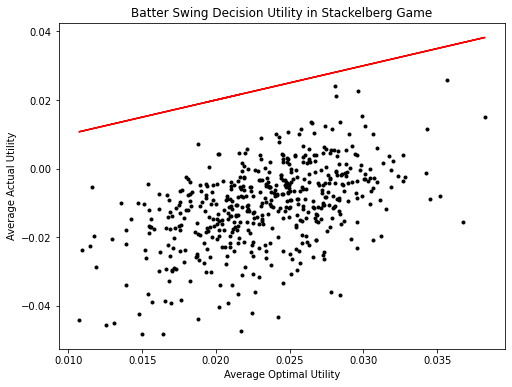

In [123]:
#plot the average expected optimal utility with the actual average utility 
fig = plt.figure(figsize = (8,6))
plt.plot(batter_results.avg_expected_optimal_utility.values, batter_results.actual_avg_utility.values, 'k.')
plt.plot(batter_results.avg_expected_optimal_utility.values, batter_results.avg_expected_optimal_utility.values, 'r-')
plt.xlabel('Average Optimal Utility')
plt.ylabel('Average Actual Utility')
plt.title('Batter Swing Decision Utility in Stackelberg Game')
plt.show()